In [1]:
# Connect to goggle drive
from google.colab import drive
drive.mount("/content/drive")

# Import needed libraries 
import matplotlib.pyplot as plt
import numpy

Mounted at /content/drive


In [2]:
def preview_RGB(spectral_cube, ch_1, ch_2, ch_3):
  lines, bands, samples = spectral_cube.shape
  RGB = numpy.empty((lines, samples, 3)) # Create a 'bmp' array with spatial size of ENVI 512,512 with 3 layers
  if (type(spectral_cube[0, 0, 0]) == numpy.uint16):
    RGB[:,:,0] = spectral_cube[:,ch_1,:]/numpy.amax(spectral_cube[:,ch_1,:]) # np.amax gets max value. Thus we get RGB in range [0,1]
    RGB[:,:,1] = spectral_cube[:,ch_2,:]/numpy.amax(spectral_cube[:,ch_2,:])
    RGB[:,:,2] = spectral_cube[:,ch_3,:]/numpy.amax(spectral_cube[:,ch_3,:])
  else:
    RGB[:,:,0] = spectral_cube[:,ch_1,:]
    RGB[:,:,1] = spectral_cube[:,ch_2,:]
    RGB[:,:,2] = spectral_cube[:,ch_3,:]
  plt.rcParams['figure.dpi'] = 200
  plt.imshow(RGB)
  plt.show()
  return RGB

This code below works just fine
ENVI
description = {
File Imported into ENVI}
file type = ENVI

samples = 1392
bands = 51
lines = 1040

interleave = bil
data type = 12
header offset = 0
byte order = 0

In [3]:
from PIL import Image
import os
def get_spectral_cube(dirpath, file):
  myDir = os.listdir(dirpath)
  # Read the first image define it size, define the total number of Images and get the size of future ENVI Spectral Cube
  fullpath = os.path.join(dirpath, myDir[0])
  im = Image.open(fullpath) 
  single_slice = numpy.array(im)
  [x, y] = single_slice.shape 
  spectral = len(myDir)
  print(x, y, spectral)

  # save as integers, data type = 12
  spectral_cube = numpy.ndarray(shape=(x,spectral,y), dtype=numpy.uint16)
  print(spectral_cube.shape)

  waves = []
  band=0
  for i in range(450,960,10):
    # prepare file path ################
    nu = str(i)
    ext = ".tif"
    filename = file+nu+ext
    # print(filename)
    fullpath = os.path.join(dirpath, filename)
    #print(fullpath)
    #print(i)  
    #print(band)
    ####################################

    im = Image.open(fullpath) 
    single_slice = numpy.array(im)
    #print(imarray.shape)
    spectral_cube[:,band,:]=single_slice
    band = band + 1
    waves.append(i)
  print(file, 'Ready')
  return spectral_cube, waves

In [4]:
def find_region_spectrum(cube, RGB, x1, x2, y1, y2):
  #Select an array
  RGB2 = RGB.copy()
  spectral_image = cube.copy()
  ##################################################################
  # Select pixels/ colour
  RGB2[y1:y2,x1:x2,0] = 0
  RGB2[y1:y2,x1:x2,1] = 1
  RGB2[y1:y2,x1:x2,2] = 0
  sel = spectral_image[y1:y2,:,x1:x2]
  sel1 = numpy.sum(sel, axis = 0)
  region = numpy.sum(sel1, axis =1)/((x2-x1)*(y2-y1))
  ##################################################################
  plt.rcParams['figure.dpi'] = 150
  plt.imshow(RGB2)
  plt.show()
  return region

In [18]:
def get_spectra(spectral_cube, object_RGB, white_cube, w_RGB, waves, x1, y1, title):
  region = find_region_spectrum(spectral_cube, object_RGB, x1, x1+15, y1, y1+15)    # Selecting region  
  white_region = find_region_spectrum(white_cube, w_RGB, x1, x1+15, int(white_cube.shape[0]/2), int(white_cube.shape[0]/2) + 15)
  #white_region = find_region_spectrum(white_cube, w_RGB, int(white_cube.shape[2])-50, int(white_cube.shape[2])-35, int(white_cube.shape[0]/2), int(white_cube.shape[0]/2) + 15)

  #Plotting selected region, white and dark spectrum
  plt.plot(waves, white_region, "b")
  plt.plot(waves, region, "r")
  plt.xlabel('Wavelength, um')
  plt.ylabel(title)
  plt.show()

Main Code

1040 1392 51
(1040, 51, 1392)
Image_Cube_ Ready
1040 1392 51
(1040, 51, 1392)
Image_Cube_ Ready


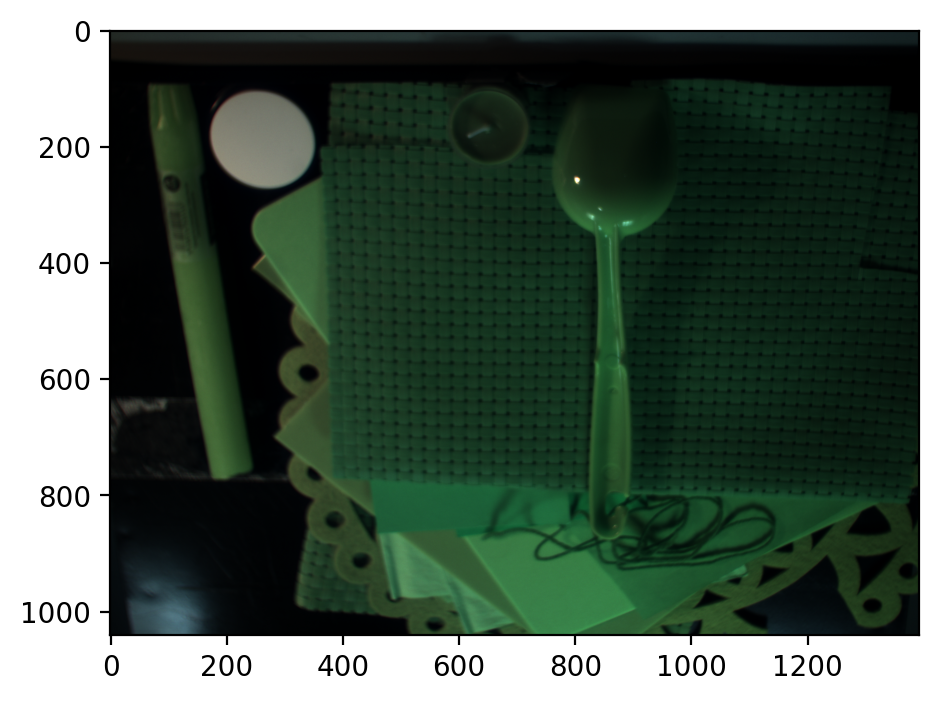

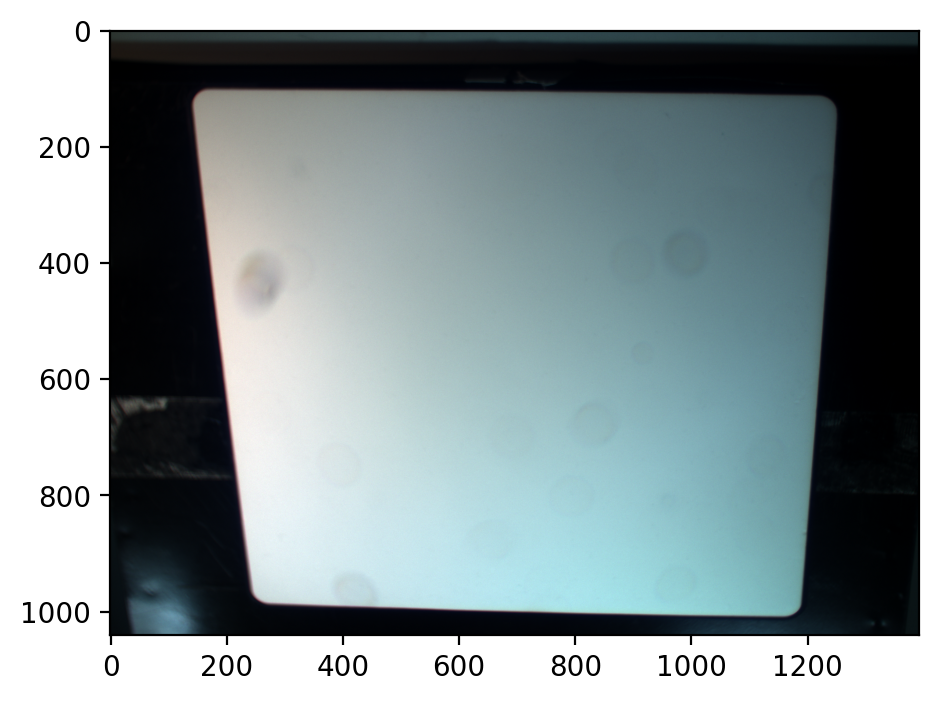

In [57]:
[ch_1, ch_2, ch_3] = [18, 8, 0]
[spectral_cube, waves] = get_spectral_cube("/content/drive/MyDrive/Summer School/ASI course 2021/Measurement sessions (Group5)/Group5_1/Nuance/GreenMeasurement/", "Image_Cube_")
[white_cube, w_waves]    = get_spectral_cube("/content/drive/MyDrive/Summer School/ASI course 2021/Measurement sessions (Group5)/Group5_1/Nuance/WhiteMeasurement/", "Image_Cube_")

# spectral_cube = spectral_cube[110:950, :, 250:1150 ]
# white_cube  = white_cube[110:950, :, 250:1150 ]

object_RGB    = preview_RGB(spectral_cube, ch_1, ch_2, ch_3)
w_RGB         = preview_RGB(white_cube, ch_1, ch_2, ch_3)

# Using Element Wise for white correction

In [8]:
def element_wise(image_data, RGB2, obj_x1, obj_y1, white_x1, white_y1, waves):
  ##################################################################
  # Select obj
  x1 = obj_x1
  x2 = obj_x1 + 10
  y1 = obj_y1
  y2 = obj_y1 + 10
  RGB2[y1:y2,x1:x2,0] = 0
  RGB2[y1:y2,x1:x2,1] = 0
  RGB2[y1:y2,x1:x2,2] = 0
  sel = image_data[y1:y2,:,x1:x2]
  sel1 = numpy.sum(sel, axis = 0)
  red = numpy.sum(sel1, axis =1)/((x2-x1)*(y2-y1))
  ##################################################################
  # Select White
  x1 = white_x1
  x2 = white_x1 + 10
  y1 = white_y1
  y2 = white_y1 + 10
  RGB2[y1:y2,x1:x2,0] = 0
  RGB2[y1:y2,x1:x2,1] = 0
  RGB2[y1:y2,x1:x2,2] = 0
  sel = image_data[y1:y2,:,x1:x2]
  sel1 = numpy.sum(sel, axis = 0)
  white = numpy.sum(sel1, axis =1)/((x2-x1)*(y2-y1))

  plt.rcParams['figure.dpi'] = 150
  plt.imshow(RGB2)
  plt.show()

  plt.plot(waves, red, "r")
  plt.plot(waves, white, "black")

  plt.xlabel('Wavelength, um')
  plt.ylabel('Camera raw data,')
  #plt.ylabel('Reflectance [0-100]%')
  plt.show()

  # Graph After White noise correction has been made by normalisation
  red_cor = red/white
  white_cor = white/white
  plt.rcParams['figure.dpi'] = 200

  plt.plot(waves, red_cor, "r")
  plt.plot(waves, white_cor, "black")
  plt.xlabel('Wavelength, um')
  plt.ylabel('Camera raw data,')
  plt.ylabel('Reflectance [0-100]%')
  plt.show()

  # Element-wise White Correction
  [lines, bands, samples] = image_data.shape
  corr = numpy.empty((lines,bands,samples), dtype = numpy.float32)

  for i in range(0,lines):
    for j in range(0,samples):
        corr[i,:,j] = image_data[i,:,j]/white
  return corr

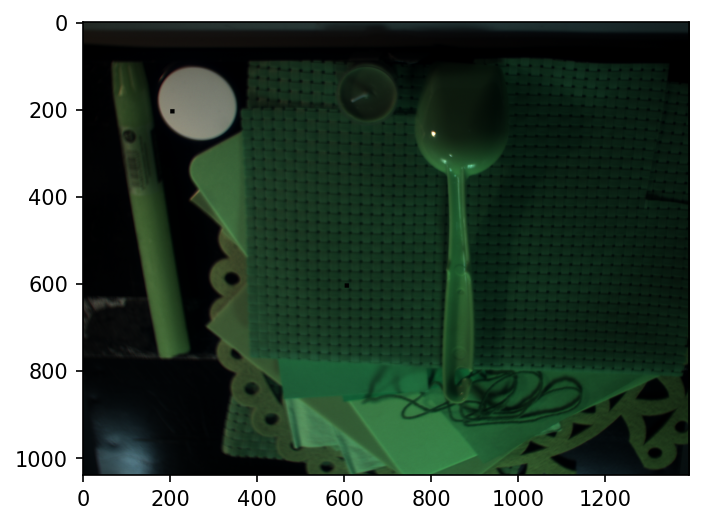

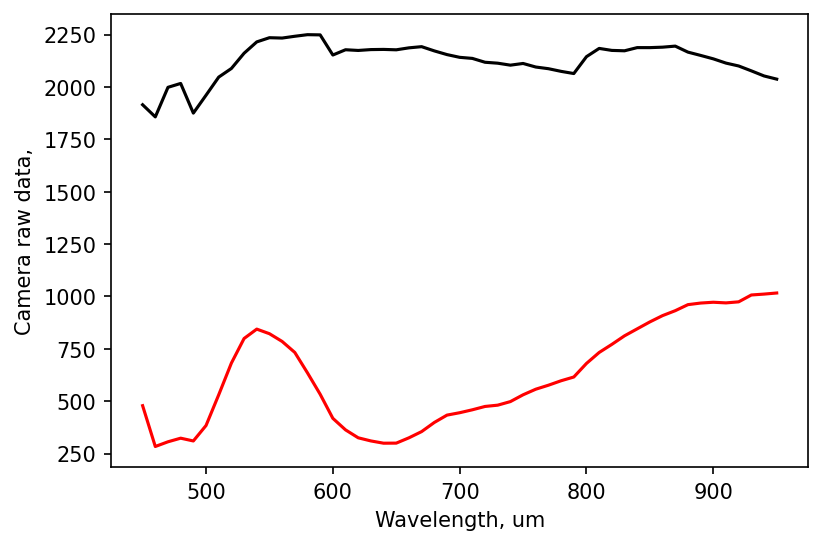

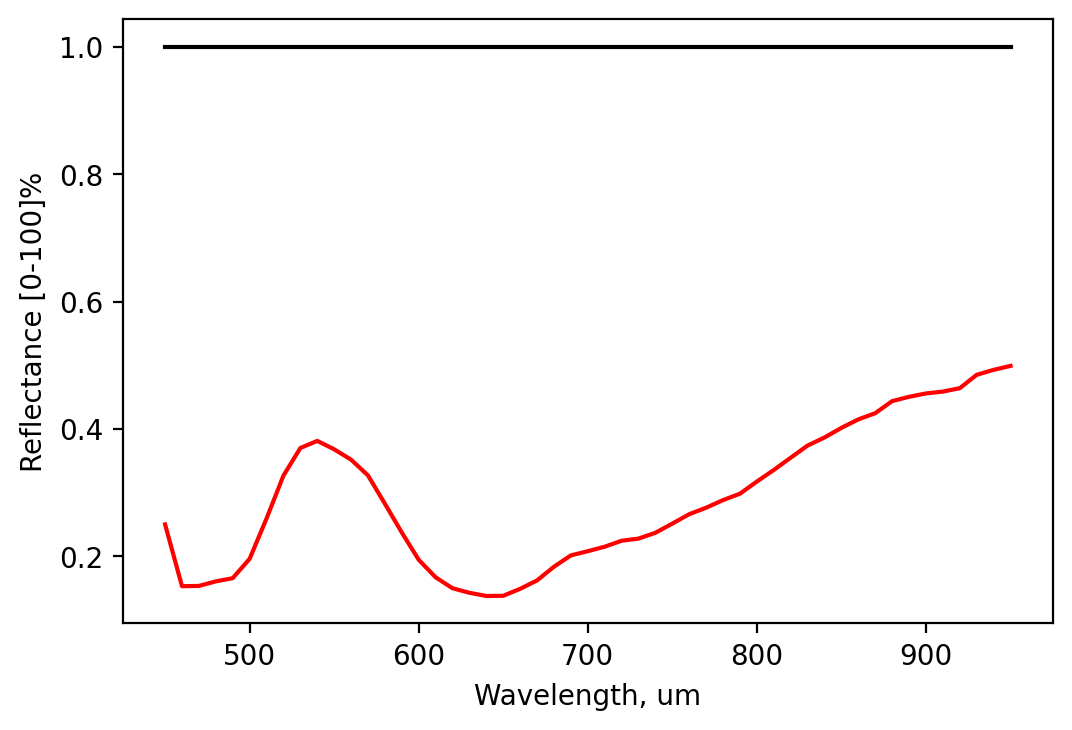

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


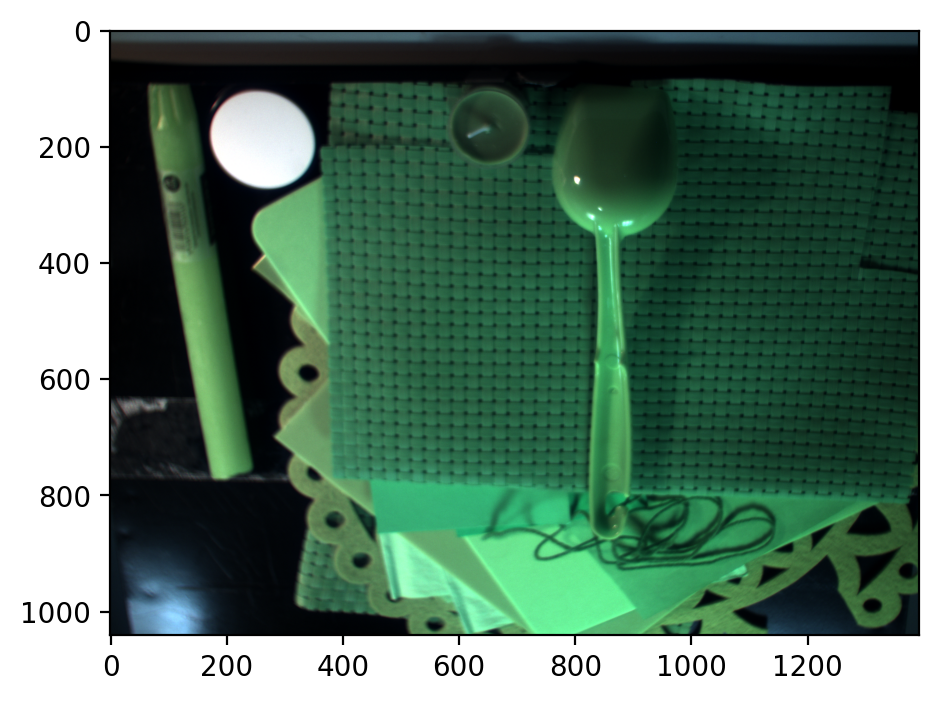

In [58]:
corr_spectral_cube = element_wise(spectral_cube, object_RGB, 600, 600, 200, 200, waves)
object_RGB = preview_RGB(corr_spectral_cube, ch_1, ch_2, ch_3)

# Using Pixel Wise for white correction

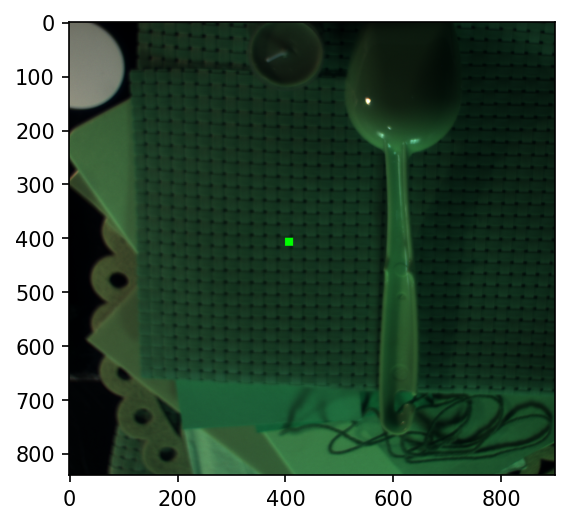

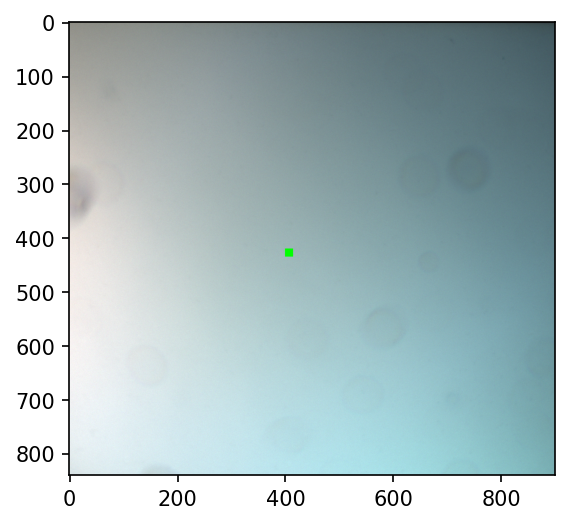

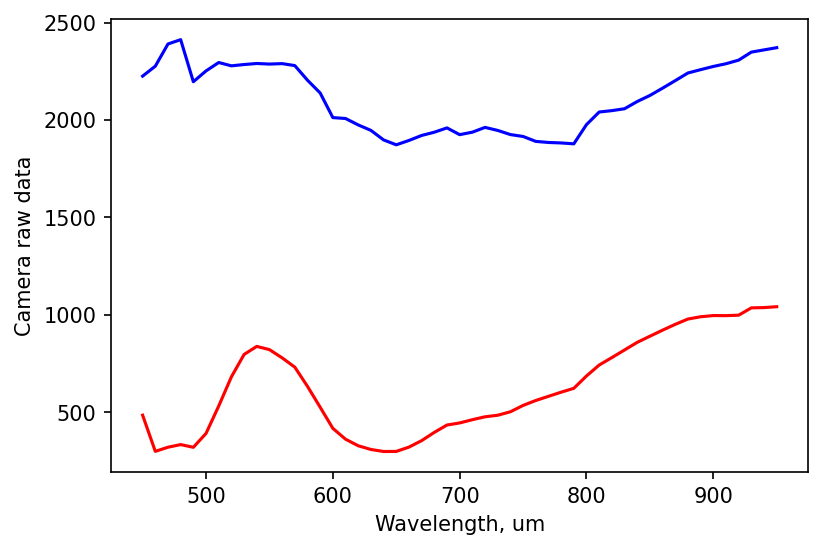

In [32]:
get_spectra(spectral_cube, object_RGB, white_cube, w_RGB, waves, 400, 400, 'Camera raw data')

In [20]:
# White Correction - Advance method
def white_correction(cube, w_cube):
  return numpy.divide(cube, w_cube)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


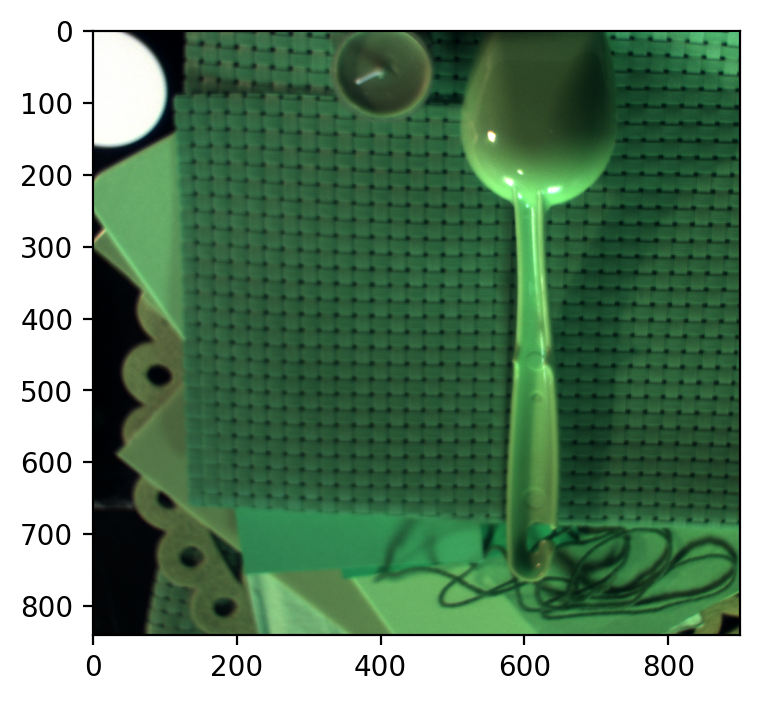

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


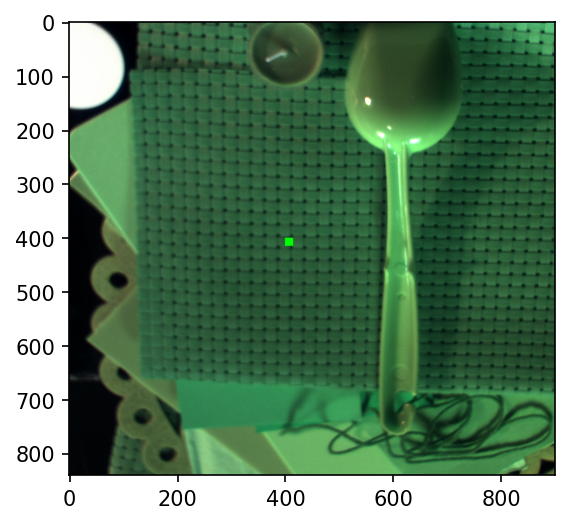

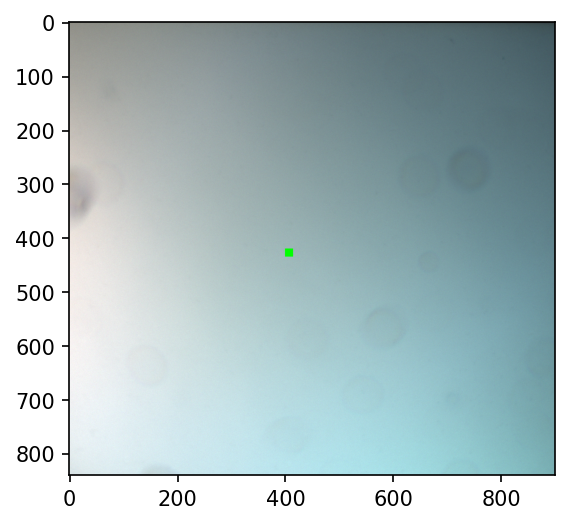

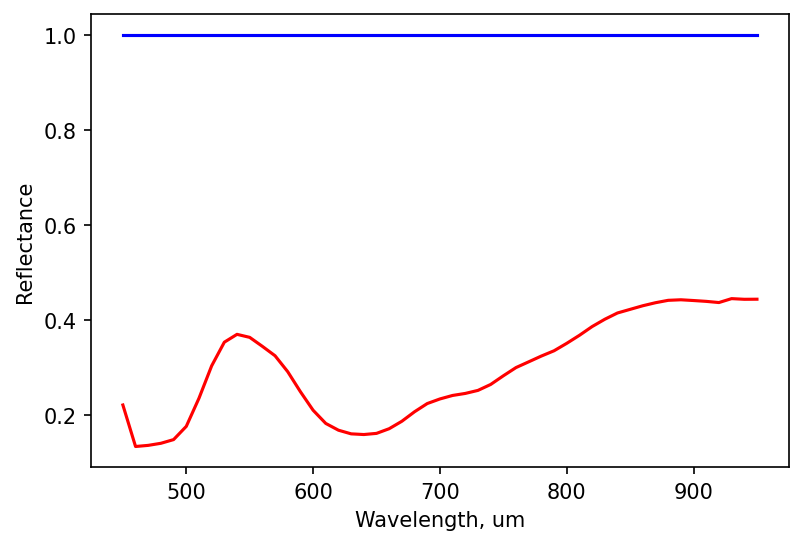

Ready


In [35]:
corr_spectral_cube = white_correction(spectral_cube, white_cube)
object_RGB = preview_RGB(corr_spectral_cube, ch_1, ch_2, ch_3)
get_spectra(corr_spectral_cube, object_RGB, white_cube/white_cube, w_RGB, waves, 400, 400, 'Reflectance')

saveraw = "/content/drive/MyDrive/Summer School/savedata/nuance_white.raw"
fileobj = open(saveraw, mode='wb')
corr_spectral_cube.tofile(fileobj)
fileobj.close()
print('Ready')

# Segmentation

In [44]:
def get_region_spectra(image_data, RGB, reg_x1, reg_y1):
  RGB2 = RGB.copy()
  ##################################################################
  # Select region
  x1 = reg_x1
  x2 = x1 + 30
  y1 = reg_y1
  y2 = y1 + 30

  RGB2[x1:x2,y1:y2,0] = 255
  sel = image_data[x1:x2,:,y1:y2]

  sel1 = numpy.sum(sel, axis = 0)
  selection1 = numpy.sum(sel1, axis =1)/((x2-x1)*(y2-y1))
  ##################################################################

  plt.imshow(RGB2)
  plt.rcParams['figure.dpi'] = 150
  plt.show()

  plt.plot(selection1) #plt.plot(waves,selection1)
  plt.xlabel('Wavelength, nm / bands')
  plt.ylabel('Reflectance [0-100]%')
  plt.title("Average spectrum of selected area")
  plt.show()
  
  return selection1

In [11]:
def segmentation(bands, threshold, selected, image_data, RGB):
  # Generate Band based condition
  n = len(bands) # the number of important bnds
  bbands = numpy.asarray(bands, dtype=numpy.uint16)

  # ratio is an array of ratios: ratio[n]=selcted[bbands[n+1]]/selected[bbands[n]]
  ratio = numpy.zeros(n-1) # array of ratios: ratio[n]=selcted[bbands[n+1]]/selected[bbands[n]]
  for i in range(n-1):
    ratio[i] = selected[bbands[i]]
  ###################################################################################################
  # now we make a new 'small_spectral_cube' made of selected bands from 'spectral_cube'
  [s1, s2, s3] = image_data.shape
  print(s1, s2, s3)
  small_spectral_cube = numpy.empty((s1, s3, n), dtype=numpy.float32)
  i=0
  for band in bbands:
    small_spectral_cube[:,:,i] = image_data[:,band,:]
    print(band)
    i=i+1
  print('RGB: ', RGB.shape)
  print('cube: ', image_data.shape)
  print('small cube: ', small_spectral_cube.shape)

  ###################################################################################################
  mask = RGB.copy()

  for i in range(s1):  #s1
    for j in range(s3): #s3
      criteria = 0
      for ch in range(n-1):
        #mask[i,j,0]=1
        if numpy.abs((small_spectral_cube[i,j,ch]-ratio[ch]))> threshold: #[0.02 - 0.18] threshold
          criteria = 1
          # ´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´
          gray_color = (mask[i,j,0] + mask[i,j,1] + mask[i,j,2])/3 # make mask gray scale and only selection RGB
          mask[i,j,0]=gray_color
          mask[i,j,1]=gray_color
          mask[i,j,2]=gray_color                       
          # ´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´
      if criteria == 0:
        pass

  print(numpy.amax(small_spectral_cube))
  print(numpy.amax(mask))
  print(numpy.amax(RGB))
  ###################################################################################################

  plt.show()
  plt.rcParams['figure.dpi'] = 200
  plt.imshow(mask)

  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


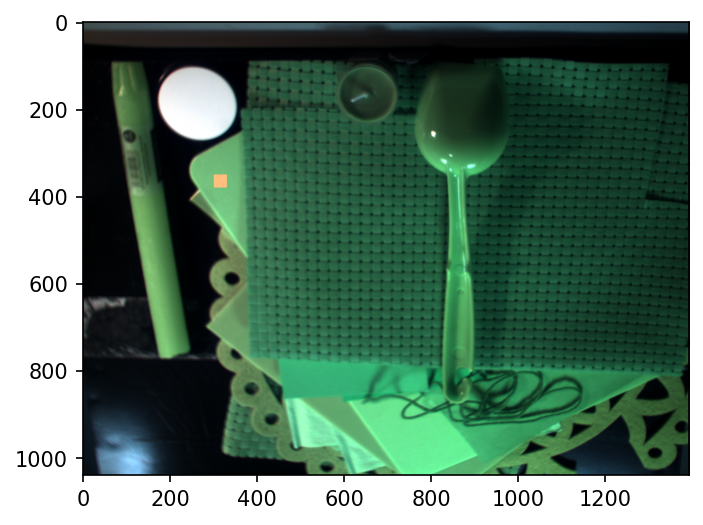

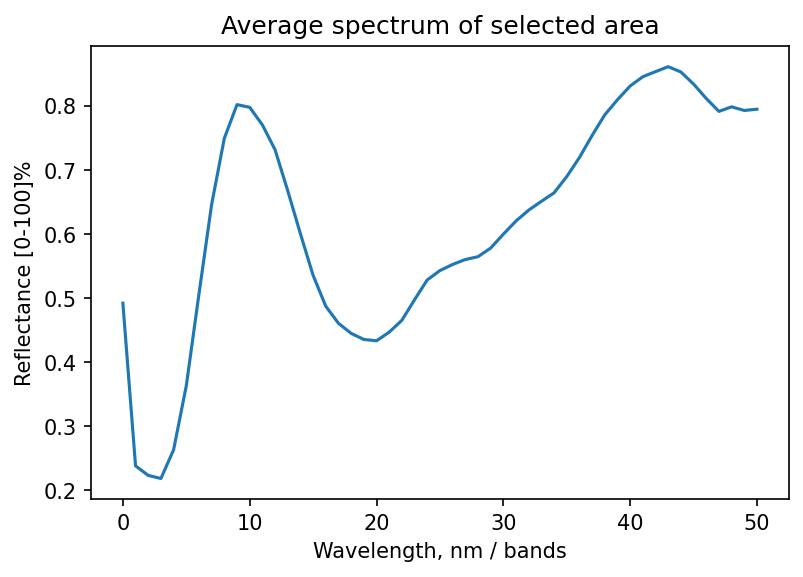

In [60]:
selection = get_region_spectra(corr_spectral_cube, object_RGB, 350, 300)

1040 51 1392
2
5
7
10
12
15
17
20
25
30
35
40
45
RGB:  (1040, 1392, 3)
cube:  (1040, 51, 1392)
small cube:  (1040, 1392, 13)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0622606
1.9461013078689575
2.1112382411956787


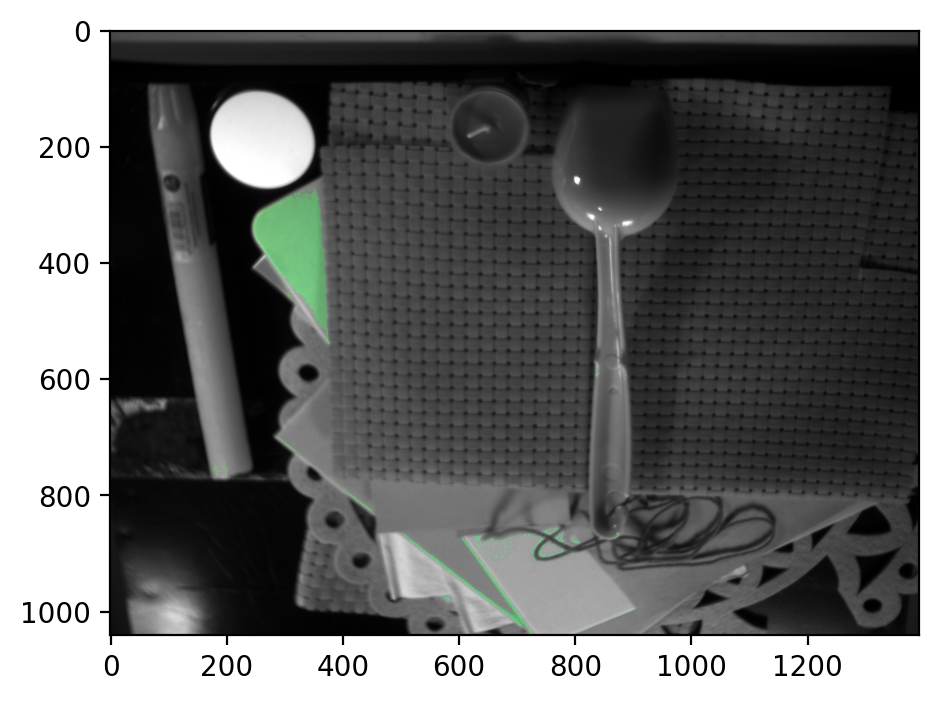

In [62]:
bands = [2, 5, 7, 10, 12, 15, 17, 20, 25, 30, 35, 40, 45]
segmentation(bands, 0.13, selection, corr_spectral_cube, object_RGB)